Plotting Lightcurves with Swift BAT Data
----------------------------------------

This example shows how to plot a Swift BAT Lightcurve, rebin it, and fit the background.

---

First, we import the [`BatLightcurve`](https://astro-gdt-swift.readthedocs.io/en/latest/api/gdt.missions.swift.bat.lightcurve.BatLightcurve.html) class, which is the interface to the 4-channel lightcurve file, and then we utilize it to open a file.  Once we open the file, we can print the handle to see some basic information about the data contained in the file.

In [1]:
from gdt.missions.swift.bat.lightcurve import BatLightcurve
bat_data = BatLightcurve.open('data/sw00974827000bev1s.lc.gz')
print(bat_data)

<BatLightcurve: sw00974827000bev1s.lc.gz;
 trigger time: 612354468.864;
 time range (np.float64(612354228.5), np.float64(612355431.5));
 energy range (np.float32(15.0), np.float32(350.0))>


Now, to plot the lightcurve, we import the [`Lightcurve`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.plot.lightcurve.Lightcurve.html) class from the gdt-core package.  Because the BAT lightcurve data is actually comprised of 4 energy channels, we need to integrate over the energy channels.  In this example, we will choose to integrate over all of the energy channels, which is the default behavior in the GDT.  This is done by calling the [`.to_lightcurve()`](https://astro-gdt-swift.readthedocs.io/en/latest/api/gdt.missions.swift.bat.lightcurve.BatLightcurve.html#gdt.missions.swift.bat.lightcurve.BatLightcurve.to_lightcurve) method.  When plotting, we will also hide the plotting of the lightcurve error bars to make a cleaner first plot.

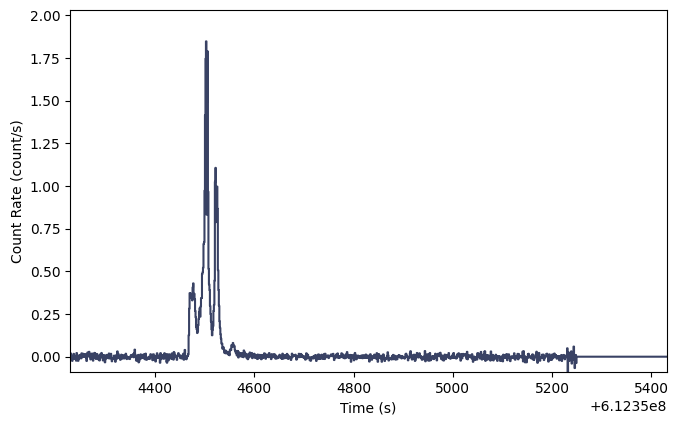

In [2]:
from gdt.core.plot.lightcurve import Lightcurve
lcplot = Lightcurve(bat_data.to_lightcurve())
lcplot.errorbars.hide()

The lightcurve plot shows the full temporal range of data in the file, integrated over the full energy range. The time is stored in the file as Swift Mission Elapsed Time (MET), so that is what is displayed on the time axis.

Now, let us rebin the lightcurve into ~4 s resolution bins.  This is done by importing the [`rebin_by_time`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.binning.binned.rebin_by_time.html) function from gdt-core, and we create a new `BatLightcurve` object by rebinning in time.

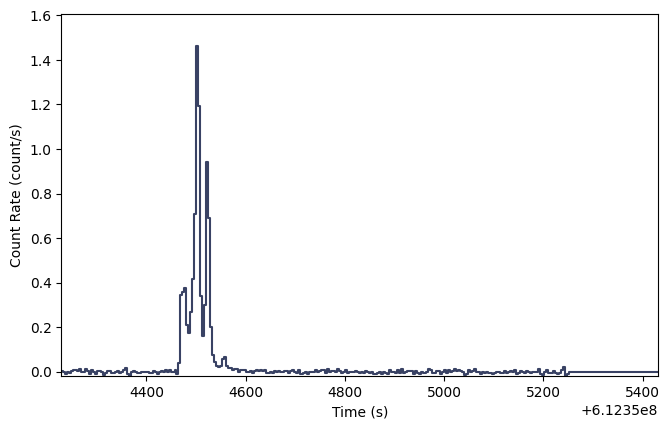

In [3]:
from gdt.core.binning.binned import rebin_by_time
bat_data_rebinned = bat_data.rebin_time(rebin_by_time, 4.0)

lcplot = Lightcurve(bat_data_rebinned.to_lightcurve())
lcplot.errorbars.hide()

We can see that most of the lightcurve now appears to be a coarser resolution than in the previous plot.  The last bin is still much longer than 4 seconds because a limitation of binned data is that one cannot rebin to higher resolution than the original data.

Finally, let us fit the background, which is a trivial exercise for BAT lightcurve data.  We import the [`BackgroundFitter`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.background.fitter.BackgroundFitter.html) class and the [`Polynomial`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.background.binned.Polynomial.html) class, the former being the interface to a variety of background fitting algorithms, and the latter being the specific background fitting algorithm that we are using. We need to define an interval of time prior to our signal, and a period of time after our signal, denoted here as `back_int1` and `back_int2` here.  Then, we initialize the `BackgroundFitter` with the data, the background fitting algorithm, and the background intervals via the [`from_phaii()`](https://astro-gdt.readthedocs.io/en/latest/api/gdt.core.background.fitter.BackgroundFitter.html#gdt.core.background.fitter.BackgroundFitter.from_phaii) method (used for binned time history spectral data).  Once initialized, we fit the background with a polynomial of order 1.

In [4]:
from gdt.core.background.fitter import BackgroundFitter
from gdt.core.background.binned import Polynomial

tstart, tstop = bat_data_rebinned.time_range
back_int1 = (tstart, tstart + 200)
back_int2 = (tstop - 600, tstop)

fitter = BackgroundFitter.from_phaii(bat_data_rebinned, Polynomial, [back_int1, back_int2])
fitter.fit(order=1)

Once the fitter has completed, we can extract our background model by interpolating it across the bins that we specify.  In this example, let us interpolate the background model over each bin in the lightcurve.  This also allows us to interpolate the background model during the time of the signal.  Then we can add the background to our lightcurve plot.

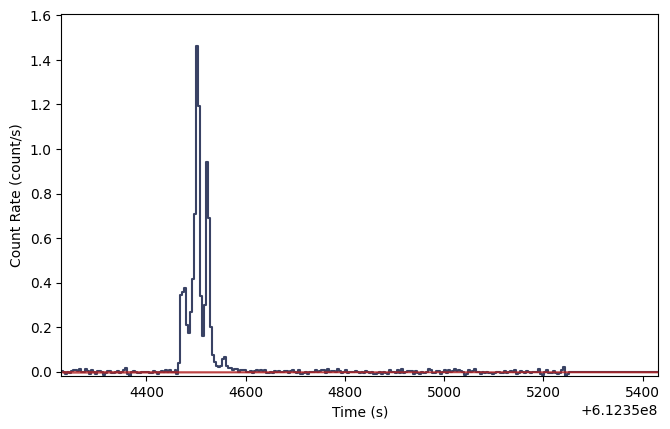

In [5]:
back_model = fitter.interpolate_bins(bat_data_rebinned.data.tstart, bat_data_rebinned.data.tstop)

lcplot = Lightcurve(bat_data_rebinned.to_lightcurve(), background=back_model)
lcplot.errorbars.hide()